# Interpolation and Regression

We are at the point in the course where we need to have a somewhat serious conversation about data fitting and inverse problems. We have dabbled in the methods through our use of interpolating polynomials to backfill ODE solutions and identify points in time or space where we achieved some targeted metric in conversion, yield, and/or selectivity.  In these cases, it was generally sufficient that we used Python's tools for 1D interpolation, even if we did not entirely understand how they work.  Now, we need to move into the analysis of kinetic data obtained in batch reactors, and it becomes important that we understand the mechanics. "Data fitting" requires us to consider the "inverse problem" of what we are used to solving. Here, we attempt to discern the models (functions) and parameter values (rate constants, reaction orders, etc.) that describe the behaviors that we observe in a system. Generally, this comprises data fitting, model reconciliation, regression, and parameter estimation. In theory, you have already learned these topics in prior courses in statistics and experimental methods. In practice, the topics are nuanced, and they can be applied in many ways to many fields of analysis. We will all benefit from learning the basics again.

We have many options for data fitting; a lot of them are built into Python, and we'll use them extensively. These include familiar tools like `scipy.interpolate.interp1D()`, `scipy.interpolate.CubicSpline()`, and `scipy.optimize.minimize()`. We'll also look at some new tools for curve fitting like `np.polyfit()`. More recently in the wider world, there has been a lot of development around using artificial intelligence for parameter estimation (this is the gist of machine learning). The core tools for machine learning are based on fundamental concepts in regression analysis, so future work in AI and Machine Learning benefits from a strong foundation in the methods of interpolation and regression.  

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from math import ceil, floor
import scipy.stats as stats
import time

## Interpolation vs. Regression

In this Notebook, we will (eventually)do a deep dive into ***linear regression***. The methods we discuss here are the same as those that operate behind the scenes when you use Excel's trendlines or Python's `np.polyfit()`. These concepts also form the basis of advanced modelling-and-prediction algorithms used in Machine Learning. If you can understand how to build interpolating polynomials and regression polynomials (and how the two are different) using linear algebra, this will provide an excellent foundation for work in data analytics. Before we get into mathematical details, we should discuss some fundamental ideas about interpolation and regression. These techniques both involve similar mechanics, and they involve developing a model that describes observed data, but they have some key differences.

When we develop an ***interpolating function***, we build a model that ***passes exactly through all of the data points that we have available***. Typically, we use these to infer un-measured values that are ***between the limits of values that we have measured***.  Think about linear interpolation to find a value between two points on a steam table as an example.  Or, if you like, think about how we've used interpolating polynomials in this course to find, say, the Volume required to achieve a specific fractional conversion after integrating a PFR model with numerical methods. 

When we perform ***regression***, we build a model that ***minimizes the error between it and the measurements we've made***.  It will not pass through all data points; in fact, it may not pass through any of our measured data points. Regressed models are what we use when we have overdetermined systems. They still provide predictive power in that they will let us predict the state of our system for a given set of inputs, and we should still generally only use them for interpolation unless we know that the model we have developed is physics-based and extensible to states that we have not measured.

We'll cover basic methods for polynomial interpolation first because this is ultimately just solving linear systems of equations. Once you understand how to construct interpolating polynomials, then linear regression is a straightforward extension of that. We will not cover the development of spline polynomials (piecewise polynomials) here, although we may still use them through Python's interpolation packages.

## The Utility of Functions

It is worth refreshing our understanding of functions.  Basically, a function is something that maps the value of an input (e.g., $x$) to the value of an output (e.g., $y$). We can generalize this concept to any sort of process that we want to model, which is what makes the basic concept of a function so useful: if you have a function that accurately describes your system, then you can predict the metric of interest (here, "$y$") for any value of input that your process takes (here, "$x$").

You can think of this in terms of all kinds of processes. As a chemical engineer, I might be interested in how much benzene my reactor produces as a function of temperature. With that function in hand, I can easily model how changing ***temperature*** will impact ***benzene production***. But this can really be any sort of model that captures either a fundamental dependence (change in rate constant with temperature) or a corrleation (let's just say that the price of bitcoin varys as a function of rainfall in Myanmar because that's as good a predictor of BTC price as anything else). Once you know how BTC price changes with fluctuations in Burmese precipitation, then you can predict the BTC price by monitoring something physically tangible (rainfall in Myanmar).

You get the idea: we use functions to build ***models*** that describe a process of interest. These models are always populated by one or more input variables (arguments) and one or more parameters that help us to define the shape of response in output variable as we vary an input variable.

### Univariate Functions f(x)

For now, we restrict consideration to univariate functions, which means a function that has only one input variable.  I will use $y = f(x)$ for all examples. ***Univariate*** means that, once our function is parameterized, we only need the value of one input argument, $x$, to predict the value of $y$. We talk a lot about polynomials, which are functions of variable order, where order is the value of the highest exponent on $x$ in your model. For example:

#### Zero order

$$y(x) = 5x^0$$

The function is zero order because the exponent on $x$ is $0$, and $x^0 = 1$. In practice, we'd never write $x^0$ since we know that it is just equal to $1$, but it is helpful to begin with a rigorous illustration of what a zero-order polynomial in $x$ actually means. This will lead naturally to characterizing the behavior of higher order polynomials.

$$y(x) = 5$$

One might describe this model as one where the value of y is predicted for a given value of x by (1) raising $x$ to the zero power and then (2) multiplying that result by a constant parameter, $5$.

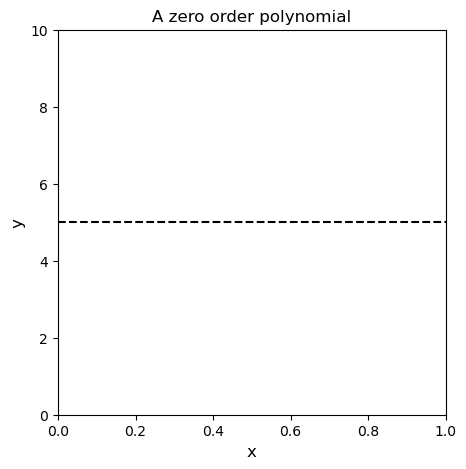

In [70]:
####################################################################
# Create an array of x values, which will be "inputs" to model     #
####################################################################

x0 = np.linspace(0,1,10)

####################################################################
# Map input values of x to resultant values of y for y = 5         #
####################################################################

y0 = np.zeros(len(x0)) + 5.0

####################################################################
# Graph y(x) for input array x0                                    #
####################################################################

plt.figure(figsize = (5, 5))
plt.plot(x0, y0, color = 'black', linestyle = 'dashed')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.ylim(0,10)
plt.xlim(min(x0), max(x0))
plt.title('A zero order polynomial')
plt.show()

#### First order

$$y(x) = 10x^1 + 5x^0 = 10x +5$$

The highest exponent on $x$ here is $1$, so this is a first order polynomial. When something has a highest order $1$, we call it a linear model because, when you graph it, it is a straight line. We see that this is a univariate function that takes a single input argument $x$. It is also populated by two constant parameters -- in this linear model, we would call the constant "5" the y-intercept, and we would call the constant coefficient of $x^1$ $(10)$ the slope. We should be able to see that if we pass a value of $x$ into this function, it will generate the corresponding value of $y$.

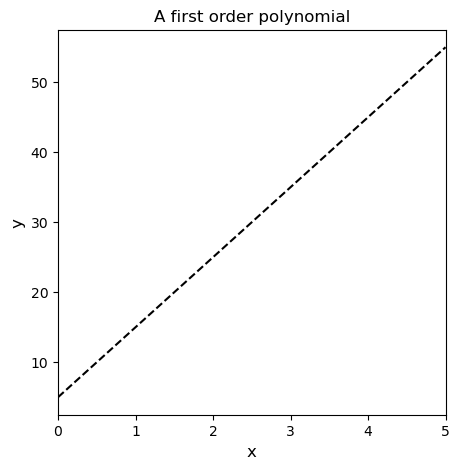

In [71]:
####################################################################
# Define an array of x values that will be "inputs" to model       #
####################################################################

x1 = np.linspace(0, 5, 10)

####################################################################
# Define function to map x value to corresponding y value          #
####################################################################

y1 = lambda x: 10*x + 5

####################################################################
# Graph y vs. x for the linear model                               #
####################################################################

plt.figure(figsize = (5, 5))
plt.plot(x1, y1(x1), color = 'black', linestyle = 'dashed')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.xlim(min(x1), max(x1))
plt.title('A first order polynomial')
plt.show()

#### Second order

$$y(x) = 0.5x^2 + 10x^1 + 5x^0 = 0.5x^2 + 10x + 5$$

Here, we have a second order (quadratic) since the leading term has an exponent of $2$ on $x$. We have now introduced curvature to the model and can visualize the result in the cell below. Before proceeding, consider that since we know the numerical values of all constants in this model, passing a value of $x$ to this function will generate the corresponding value of $y$.

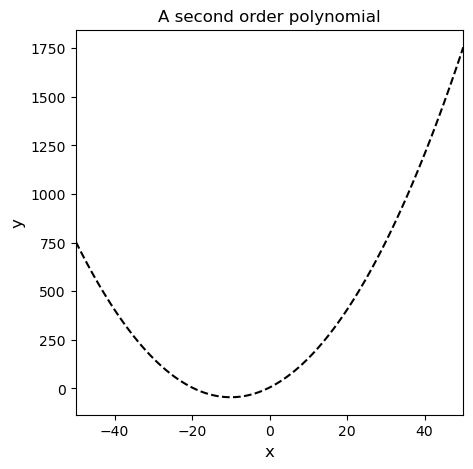

In [72]:
####################################################################
# Define an array of x values that will be "inputs" to model       #
####################################################################

x2 = np.linspace(-50, 50, 100)

####################################################################
# Define function to map x value to corresponding y value          #
####################################################################

y2 = lambda x: 0.5*x**2 + 10*x + 5

####################################################################
# Graph y vs x                                                     #
####################################################################

plt.figure(figsize = (5, 5))
plt.plot(x2, y2(x2), color = 'black', linestyle = 'dashed')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.xlim(min(x2), max(x2))
plt.title('A second order polynomial')
plt.show()

We can proceed indefinitely with polynomials and, at this point, can probably imagine imagine 3rd, 4th, and a general "nth" order polynomial:

#### Third order

$$y(x) = -0.75x^3 + 0.5x^2 + 10x + 5$$

#### Fourth order

Wwe can visualize the increasing complexity and curvature of $3^{rd}$ and $4^{th}$ order polynomials in the cell below.

$$y(x) = 0.035x^4 - 0.75x^3 + 0.5x^2 + 10x + 5$$

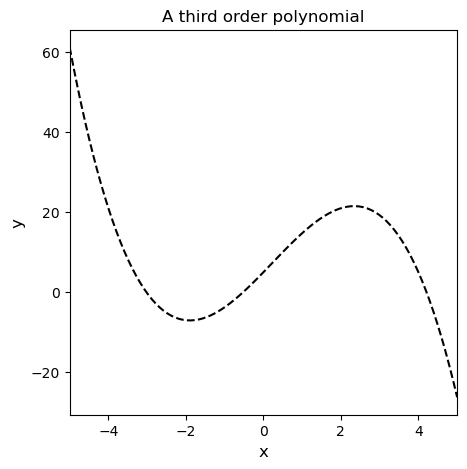

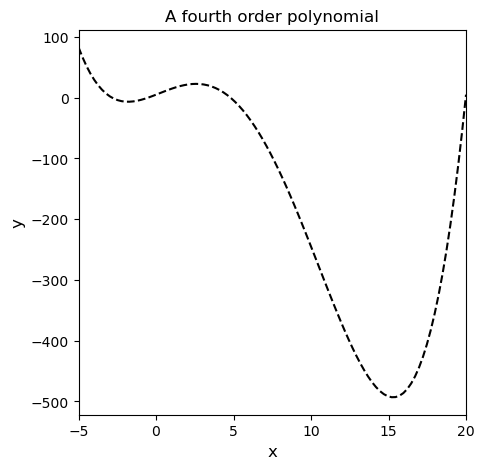

In [73]:
########################################################################
# Define an array of x values that will be "inputs" to 3rd order model #
########################################################################

x3 = np.linspace(-5, 5, 100)

########################################################################
# Define a 3rd order function to map x value to corresponding y value  #
########################################################################

y3 = lambda x: -0.75*x**3 + 0.5*x**2 + 10*x + 5 

########################################################################
# Graph 3rd order polynomial on domain for x3                          #
########################################################################

plt.figure(figsize = (5, 5))
plt.plot(x3, y3(x3), color = 'black', linestyle = 'dashed')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.xlim(min(x3), max(x3))
plt.title('A third order polynomial')
plt.show()

########################################################################
# Define an array of x values that will be "inputs" to 4th order model #
########################################################################

x4 = np.linspace(-5, 20, 100)

########################################################################
# Define a 4th order function to map x value to corresponding y value  #
########################################################################

y4 = lambda x: 0.035*x**4 - 0.75*x**3 + 0.5*x**2 + 10*x + 5 

########################################################################
# Graph 4th order polynomial on domain for x4                          #
########################################################################

plt.figure(figsize = (5, 5))
plt.plot(x4, y4(x4), color = 'black', linestyle = 'dashed')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.xlim(min(x4), max(x4))
plt.title('A fourth order polynomial')
plt.show()

#### nth order

Although it is a bit abstract, it will become conceptually and mathematically useful if we can define the general functional form of an $n^{th}$ order polynomial:

$$y(x) = \alpha_{n}x^{n} + \alpha_{n-1}x^{n-1} \ ... \ + \ 0.035x^4 - 0.75x^3 + 0.5x^2 + 10x + 5$$

## Data Modelling: The Inverse Problem

Above, we simply showed that given a fully-parameterized function (a model), we can then use it to predict the value of the output for any value of input supplied to that function.

```{note}
By "fully parameterized function," we mean a function in which the numerical value and dimensions are known for all constants that appear in the function. These include slopes, y-intercepts, and any coefficient that appears in the model.  The argument of the function ($x$ in the above illustrations) is not a parameter -- it is an input that we supply to the function.
```

When we set out to analyze data, we are in the inverse position in that we do not yet have a fully parameterized model. We may not even know what type of function we should use to model our data, and we definitely do not know the values of any constant parameters that might appear in that as yet unknown function. Usually, at the start of a data analysis problem, we will only have a discrete set of observed values of our output (e.g., $y$ or the price of BTC) that we have measured at various values of our input (e.g., $x$ or rainfall in Myanmar). We would ***like to have*** a function (model) that tells us explicitly how our output (BTC price) changes as a function of our input (Burmese rainfall), but the key is that we have only data and we do not know the function or its parameters yet - we have to build the model by analyzing the data. ***This is the core of the inverse problem*** in data analysis.

Before proceeding, we should consider the difference between interpolation and extrapolation.  ***Interpolation*** is the process of inferring the value of an output, $y$, for a value of input, $x$, that we did not test; however, the untested input lies ***between*** input values that we did test (i.e., between measurements we have already made). ***Extrapolation*** is the process of forecasting the value of an output, $y$, at a value of input, $x$ that we did not test ***and lies outside*** of the range of input values that we have tested. Interpolation is always safer than extrapolation, but you can see why the ability to extrapolate to input values that you haven't measured would be useful: 

"Wow, it has never rained 145 inches in Burma in a day before! I wonder what this will do to the price of BTC?"

Loosely, we will look at two possible approaches to developing a model from data. The first is to construct an "interpolating polynomial," which we will define loosely as a function that passes exactly through each data point of interest. The second is a "regression polynomial," which we will loosely define as a function that produces the line of best fit through all data of interest. By "best fit," we mean the model that gives the least possible error between our measurement and our prediction of that measurement. Regardless of the approach, it is most intuitive to start by framing this problem using systems of equations. This will form a solid foundation for the more complicated topics in model fitting and parameter estimation.

### Converting data into a system of equations

The basic idea is that we are in a situation where we have data available to us. We can imagine sourcing this data oin many ways. For example, we could design an experiment in which we adjust values of our input, $x$, and we mesure values of the response, $y$. In some cases, we may be working with systems for which extensive data already exists through measurements made by others. In these cases, we might mine databases to find values of an output, $y$, at varying values of an input, $x$. The general conceputal idea is that we want to amass as much data as we can that would inform us about how the a value of an output of interest (e.g., the price of BTC) changes upon varying the value of an input. In the general sense, an input for this model could be anything that we expect will determine the value of our output in some way (e.g., rainfall in Myanmar). 


```{note}
For now, we'll keep it simple: we will have an output of interest called $y$ and a significant input $x$. In familiar terms, these would be the dependent variable, $y$, and independent variable, $x$. For reasons that may become apparent as we move forward, the minimum size set of data that we will consider is one comprised of 2 measurements (two $(x,y)$ pairs). The reason we are starting with 2 data points is that if we only make a single measurement, (say $y = 5$ when $x = 7$), then the only valid prediction that we can is that $y = 5$ when $x = 7$. There is no way for us to build additional insights about the value that $y$ might take at a different value of $x$. Once we get to two measurements, we can start to build more useful models. The mathematical reason for this will become more clear once we look at the methodology.
```

We have two $(x,y)$ measurements. Specifically, when $x = 1$, $y = 4$ and when $x = 2$, $y = 7$.  More concisely, these are two $(x,y)$ pairs: $(1,4)$ and $(2,7)$.

Let's put those on a scatter plot!

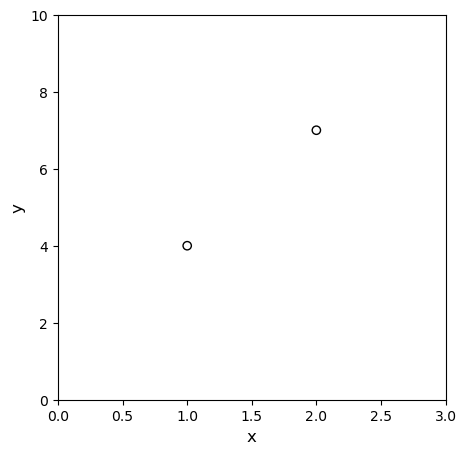

In [74]:
#######################################################################
# Define x,y data sets                                                #
#######################################################################

x = [1, 2]
y = [4, 7]

#######################################################################
# Graph y vs x                                                        #
#######################################################################

plt.figure(figsize = (5, 5))
plt.scatter(x,y, marker = 'o', color = 'none', edgecolor = 'black')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.ylim(0,10)
plt.xlim(0,3)
plt.show()

Looking at the data points in the graph above, we can intuit something very fundamental about data fitting. It should be visually very clear now that if we intend to draw a straight line (a linear model!) through these two data points, there is ***exactly one line that will pass through both points***. If, on the other hand, we want to put a curved line through them...well...there are an infinite number of quadratic, cubic, quartic, etc. functions ($2^{nd}$, $3^{rd}$, and $4^{th}$ order models) that will pass exactly through both points. Conversely, if we were to attempt to draw a horizontal line (a zero order model) through both points, we find that no such line exists! 

There is a really clear mathematical reason for this -- it has to do with the system being fully determined (first order), overdetermined (zero order) or underdetermined (2nd order or higher). We can demonstrate this by using a proposed model (function) to convert our data into a system of equations. First, let's combine our measured values with our proposal that a linear model (straight line) is an appropriate description of the relationship between $x$ and $y$. The general equation for a line expressed with an unknown slope (m) and an unknown y-intercept (b) is: 

$$y(x) = mx^1+bx^0 = mx + b$$

With that equation in mind, we note that we have two measured $(x,y)$ pairs, and that these pairs can be substituted into the model function to construct a linear system of equations:

\begin{align}
    4 = 1m+b\\
    7 = 2m+b\\
\end{align}

Now this looks like an algebra problem!! The nature of the inverse problem reveals itself -- we know the values of the independent variables, $x$, and the corresponding values of the dependent variables, $y$, but ***we do not know the coefficients $(m, b)$ in the polynomial that describe the line***.  The core of the inverse problem is to find these coefficients.  In this case, we have 2 equations, written in terms of 2 unknowns $(m and b)$. The system of equations is fully determined, and there is one unique solution:

\begin{align}
    m = 3\\
    b = 1\\
\end{align}

If we overlay our data on that line, we'll find that it passes through both points exactly.

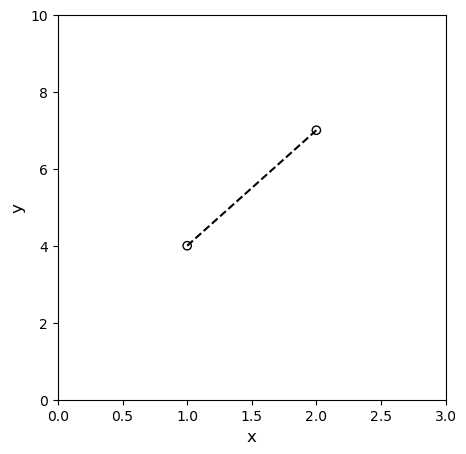

In [75]:
###########################################################################
# Define (x,y) data pairs                                                 #
###########################################################################

x = np.array([1, 2])
y = np.array([4, 7])

###########################################################################
# Define the parameterized first order model                              #
###########################################################################

m = 3
b = 1
yline = lambda x: m*x + b

###########################################################################
# Use the first order model to graph values of y on domain x = [1, 2]     #
###########################################################################

xline = np.linspace(1, 2, 100)
plt.figure(figsize = (5, 5))
plt.scatter(x,y, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.ylim(0,10)
plt.xlim(0,3)
plt.show()

The above exercise illustrates the basic approach for constructing an "interpolating polynomial" that passes exactly through measured data and facilitates prediction of observables at points between the locations of our measurements. We have constructed a function (a line) that passes through each of point exactly. We should be able to visualize that, for the pair of data points considered here, there is one and only one line that passes exactly through each data point, and it is $y(x) = 3x + 1$

To illustrate an overdetermined system, if we instead try propose that a zero order polynomial $(y = C, \ \mathrm{where \ C \ is \ a \ constant})$ could be used to describe the relationship between $x$ and $y$, we would substitute our two $(x,y)$ pairs into the zero order model form to get:

\begin{align}
    4 = C\\
    7 = C\\
\end{align}

We would conclude that there is no solution here. There is no constant, at least in normal mathematics, that simultaneously equals 4 and 7. That is to say, you need at least a first order polynomial to be able to pass through both data points.

To illustrate an underdetermined system, consider what happens if we try to fit a second order polynomial to this pair of data points. Recall that the general expression for a $2^{nd}$ order polynomial is:

$$y(x) = \alpha_2x^2 + \alpha_1x^1 + \alpha_0x^0 = \alpha_2x^2 + \alpha_1x + \alpha_0$$

We have two data points, so we could write two quadratic equations by substituting each $(x,y)$ into a quadratic function:

\begin{align}
    4 = 1\alpha_2 + 1\alpha_1 + \alpha_0\\
    7 = 4\alpha_2 + 2\alpha_1 +  \alpha_0\\
\end{align}

This system has no unique solution. There are 2 equations written in terms of 3 unknowns ($\alpha_0$, $\alpha_1$, and $\alpha_2$). The system is underdetermined (not enough constraints), and we can find an infinite number of ($\alpha_0$, $\alpha_1$, $\alpha_2$) sets that will create 2nd order polynomials that pass exactly through each point. So the corollary to the above statement about a 0 order polynomial is that there are an infinite number of 2nd order polynomials that will describe this data.


```{note}
These ideas generalize to larger and larger data sets. The general concept is that, when given $n+1$ data points, you can fit an $n_{th}$ order polynomial that passes exactly through those $n+1$ data points. If your polynomial is lower order than $n$, the system is overdetermined (too many constraints), and you can't find a unique solution. If your polynomial is higher order than $n$, the system is underdetermined (too few constraints), and you can't find a unique solution.
```  

### A Quadratic Example

Let's work through a concrete illustration of the concept that you can find a unique, $n^{th}$ order polynomial to pass exactly through $n+1$ data points. We will consider the scenario where we have made 3 $(x,y)$ measurements:  (1,8), (2,4), and (3,6). Because we have 3 data points, we can find a unique, 2nd order (quadratic) polynomial that goes through each data point.

First, it's always helpful to plot raw data. This provides us with an immediate sense of things like imprescision, scatter, and curvature.

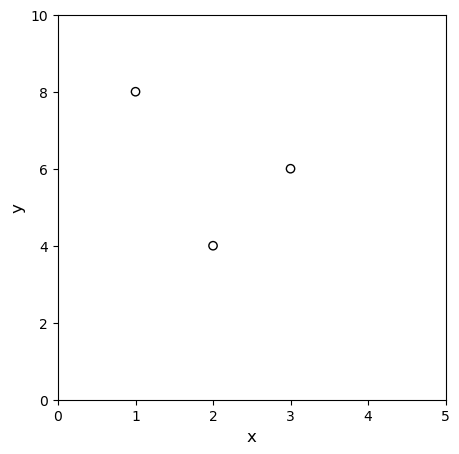

In [76]:
#########################################################################
# Defining the 3 (x,y) pairs comprising our data set                    #
#########################################################################

x = [1, 2, 3]
y = [8, 4, 6]

#########################################################################
# Plotting the 3 (x,y) pairs                                            #
#########################################################################

plt.figure(figsize = (5, 5))
plt.scatter(x,y, marker = 'o', color = 'none', edgecolor = 'black')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.ylim(0,10)
plt.xlim(0,5)
plt.show()

If we inspect the graph above, we should be able to see that only a curved line will be able to pass through each of the 3 data points exactly--it is impossible to identify a straight line that will pass through each of these 3 data points. Let's propose that a quadratic model can fit the data because this is the lowest order polynomial that will result in curvature. We start the same way that we did above when fitting a straight line: we use the data to make a system of quadratic equations by plugging $(x,y)$ pairs into the generic model for a $2^{nd}$ order polynomial, i.e., $y(x) = \alpha_2x^2 + \alpha_1x^1 + \alpha_0x^0$.  Substituting our three $(x,y)$ pairs gives:

\begin{align}
    8 = 1\alpha_2 + 1\alpha_1 + \alpha_0\\
    4 = 4\alpha_2 + 2\alpha_1 + \alpha_0\\
    6 = 9\alpha_2 + 3\alpha_1 + \alpha_0\\
\end{align}

Now we can see why we get a unique solution when fitting a $2^{nd}$ order polynomial to $3$ data points. The system of equations is fully determined--there are 3 equations and 3 unknowns ($\alpha_0$, $\alpha_1$, $\alpha_2$), so there is a unique set of ($\alpha_0$, $\alpha_1$, $\alpha_2$) values that define this data set. We find their numerical values by solving the system of equations (use whatever method you like) to get:

\begin{align}
    \alpha_2 &= 3\\
    \alpha_1 &= -13\\
    \alpha_0 &= 18\\
\end{align}

Below, we will overlay this polynomial with the original data set. Doing so, it is clear that the line passes exactly through each data point and *infers* the values of y between the measured data points.

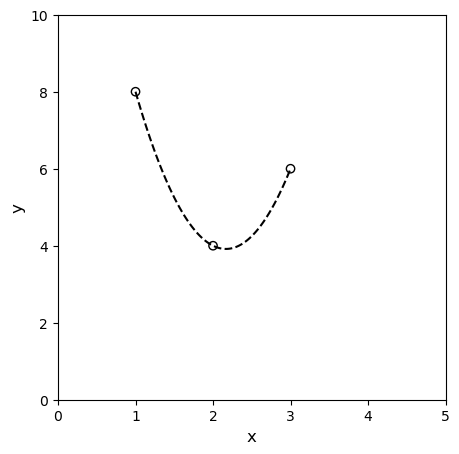

In [77]:
############################################################################################
# Define model parameters, i.e., coefficients of the polynomial                            #
############################################################################################

α2 = 3
α1 = -13
α0 = 18

############################################################################################
# Define the second order polynomial function of x                                         #
############################################################################################

yline = lambda x: α2*x**2 + α1*x + α0

############################################################################################
# graph y(x) and 3 (x,y) pairs                                                             #
############################################################################################

xline = np.linspace(1, 3, 100)
plt.figure(figsize = (5, 5))
plt.scatter(x,y, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.ylim(0,10)
plt.xlim(0,5)
plt.show()

```{important}
The above visualization should reinforce a few general concepts:

1. We have $(n+1) = 3$ data points available. This means that $n = 2$.
2. We cannot find any first $(n-1)$ order model that will pass through all three $(n+1)$ data points.
3. We can find a single second $(n)$ order polynomial that will pass through all three $(n+1)$ data points. 
4. We can find an infinite number of third $(n+1)$ order or higher order polynomials that will pass through all three $(n+1)$ data points.  
5. Only the quadratic $n^{th}$ order is "just right" because the quadratic system of equations is fully determined.

These are useful concepts, and the easiest way to generalize them to higher order systems (and minimize the tedium in solving algebraic equations on your part) is to take advantage of linear algebra.
```

## A Matrix/Vector representation of the Inverse Problem

Going back to the case of two $(x,y)$ pairs, $(1,4)$ and $(2,7)$. Recall that we were able to find first order model $y(x) = mx+b$ that passes through each $(x,y)$ pair. In doing so, we wrote the following two equations.

\begin{align}
    4 = 1m+b\\
    7 = 2m+b\\
\end{align}

To support abstraction to higher order polynomials, we will now the coefficients formerly known as "m = slope" and "b = intercept" with $\alpha_i$ values. Each $\alpha_i$ is a constant-valued coefficient, and the subscript $i$ represents the order of $x$ that particular $\alpha$ is multiplied by in the polynomial.  

\begin{align}
    4 = 1\alpha_1 + \alpha_0\\
    7 = 2\alpha_1 + \alpha_0\\
\end{align}

Let's also rearrange the equations to be consistent with typical left hand side/right hand side notation for interpolation and regression problems:

\begin{align}
    1\alpha_1 + 1\alpha_0 = 4\\
    2\alpha_1 + 1\alpha_0 = 7\\
\end{align}

We see this is nothing more than a system of equations that are all linear with respect to the coefficients. This is to say that, no matter the order on $x$, each of the $\alpha$'s has an exponent of 1. Realizing this, we can re-write this system of equations in Matrix/Vector notation:

$$\begin{bmatrix} 1 & 1 \\ 2 & 1 \\ \end{bmatrix} \times 
\begin{bmatrix} \alpha_1 \\ \alpha_0 \end{bmatrix} = 
\begin{bmatrix} 4 \\ 7 \end{bmatrix}$$

```{tip}
We've all taken linear algebra before, but maybe it has been a minute. Here's a refresher: the above equation involves matrix multiplication. In matrix multiplication, we work row by column. We multiply each element in row $i$ by each element in column $j$, and we sum the array of values generated. The sum of this array is the $[i,j]$ element in the resultant product matrix.
```` 

Breaking down these terms, we should see that the matrix on the left corresponds to the value of $x$ that is multiplied by each value of $\alpha$. We should notice that, technically, $\alpha_0$ multiplies by $x^0$, but we usually call $x^0$ 1 for simplicity. In the first row, we have values of $x_1$, which is the $x$ in our first $(x,y)$ pair $(1,4)$.  In the second row, we have values of $x_2$, which is the $x$ in our second $(x,y)$ pair $(2,7)$. If we multiply these $x$ values by the coefficients as shown above, it gives us the values of $y_1$ in the first row and $y_2$ in the second row.

$$\begin{bmatrix} x_1^1 & x_1^0 \\ x_2^1 & x_2^0 \\ \end{bmatrix} \times 
\begin{bmatrix} \alpha_1 \\ \alpha_0 \end{bmatrix} = 
\begin{bmatrix} y_1 \\ y_2 \end{bmatrix}$$

Usually, you'll see this matrix equation in the shorthand:

$$XA = Y$$

Where $X$ is a matrix of input values raised to orders that appear in the model, $A$ is a vector of coefficients that describe the specific behavior of the polynomial, and $Y$ is a vector of measured outputs at each value of the input. Since we have measured values of X and Y, then $A$ contains all of the unknowns (coefficients) in this system. This is where we leverage linear algebra to do the heavy lifting of solving for an interpolating polynomial. If this were a standard algebraic equation, we would solve for $A$ as follows:

$$A = Y/X$$

Matrices behave differently. Instead of the intuitive division operator, we don't perform Matrix division per se. We multiply by the Matrix Inverse. It is helpful to to visualize this as solving for the unknown coefficient array, $A$, by multiplying both sides of our equation by the inverse of the $X$ matrix in a series of steps:

\begin{align}
    XA &= Y\\
    X^{-1}XA &= X^{-1}Y\\
    IA &= X^{-1}Y\\
    A &= X^{-1}Y\\
\end{align}

This is the Matrix equivalent of dividing both sides of the equation by $X$. In these equations, $I$ is the identity matrix, which is the Matrix analog of the number 1 in that when we multiply $I$ by a matrix or Vector, it returns the value of that Matrix or Vector unchanged, so we drop the $I$ in the final line. Formally:

$$IA = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ \end{bmatrix} \times 
\begin{bmatrix} \alpha_1 \\ \alpha_0 \\ \end{bmatrix} = 
\begin{bmatrix} \alpha_1 \\ \alpha_0 \\ \end{bmatrix} = 
A$$

We will apply this method in the cell below. We will create an $X$ matrix and a $Y$ vector, and then we will solve for $A$ using a matrix inversion. Ultimately, we will find the exact same values of $\alpha_0$ (intercept) and $\alpha_1$ (slope) that we got above. This is just a more succinct operation; moreover, the approach is easily generalized to higher order models.  

```{caution}
Instead of actually performing a full matrix inversion as suggested by the equations above, it is more efficient to use routines built into our programming language when we solve linear systems of equations. Matrix inversions are computationally expensive, and, at least historically, this was a concern in writing efficient code. Most languages have more efficient algorithms in place that avoid full matrix inversion. 

For example, Matlab and Julia use a "left divide operator" for solving matrix equations. 

$$A = X \ \backslash \ Y$$

In Python, we use a `numpy` feature, specifically `numpyp.linalg.solve(X, Y)`
```


In [78]:
######################################################################
# Create the X matrix; it contains all independent variable values   #
# Each value appears raised to orders specified by the polynomial    #
######################################################################

X = np.array([[1, 1], [2, 1]])
print(X, '\n')

######################################################################
# Create the Y array; these are our observations/measurements        #
######################################################################

Y = np.array([4, 7])
print(Y, '\n')

######################################################################
# Solve for A; A = X^-1*Y                                            #
######################################################################

A = np.linalg.solve(X, Y)
α1 = A[0]
α0 = A[1]

print(A)
print(f'α1 = {α1:n} and α0 = {α0:n}')

[[1 1]
 [2 1]] 

[4 7] 

[3. 1.]
α1 = 3 and α0 = 1


### Matrix representation of the 2nd order problem

Matrix representation become much more useful when we got to higher order polynomials, where the size of the system is large and the algebra is tedious. Let's see if we can begin to generalize the result by applying the approach to the second order example involving 3 $(x,y)$ pairs. Recall: we are trying to fit a second ($n_{th}$ order) polynomial to 3 $(n+1) data points ($n+1$ data points): (1,8), (2,4), and (3,6)

We can substitute $(x,y)$ pairs into a general quadtratic expression to generate the following system of equations:

\begin{align}
    8 = \alpha_0 + 1\alpha_1 + 1\alpha_2\\
    4 = \alpha_0 + 2\alpha_1 + 4\alpha_2\\
    6 = \alpha_0 + 3\alpha_1 + 9\alpha_2\\
\end{align}

Which we can then put into the matrix form we developed in the previous cell:

\begin{align}
    1\alpha_2 + 1\alpha_1 + 1\alpha_0 = 8\\
    4\alpha_2 + 2\alpha_1 + 1\alpha_0 = 4\\
    9\alpha_2 + 3\alpha_1 + 1\alpha_0 = 6\\
\end{align}

And then:

$$\begin{bmatrix} 1 & 1 & 1 \\ 4 & 2 & 1 \\ 9 & 3 & 1 \end{bmatrix} \times 
\begin{bmatrix} \alpha_2 \\ \alpha_1 \\ \alpha_0 \\ \end{bmatrix} = 
\begin{bmatrix} 8 \\ 4 \\ 6 \\ \end{bmatrix}$$

It is important to realize that the above is just numbers, $(x,y)$ paris, plugged into the more general form:

$$\begin{bmatrix} x_1^2 & x_1^1 & x_1^0 \\ x_2^2 & x_2^1 & x_2^0 \\ x_3^2 & x_3^1 & x_3^0 \\ \end{bmatrix} \times 
\begin{bmatrix} \alpha_2 \\ \alpha_1 \\ \alpha_0 \\ \end{bmatrix} = 
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \end{bmatrix}$$

And so, we again arrive at:

$$XA = Y$$

We can solve this by matrix inversion to find all unknown coefficients, which we recall should be $(-18, 13, 3)$

```{important}
A key insight is that, although our models are nonlinear in $x$, all of our $x$ values are known. We are solving for coefficients, $\alpha$, and the equations that we generate in during polynomial interpolation and regression are **always** linear in the coefficients. This means that we can always use matrix methods to solve for unknown coefficients when we construct interpolating polynomials or regression polynomials. 
```

In [79]:
######################################################################
# Create the X matrix; it contains all independent variable values   #
# Each value appears raised to orders specified by the polynomial    #
######################################################################

X = np.array([[1, 1, 1], [4, 2, 1], [9, 3, 1]])
print(X, '\n')

######################################################################
# Create the Y array; these are our observations/measurements        #
######################################################################

Y = np.array([8, 4, 6])
print(Y, '\n')

######################################################################
# Solve for A; A = X^-1*Y                                            #
######################################################################

A = np.linalg.solve(X,Y)
print(A)

α2 = A[0]
α1 = A[1]
α0 = A[2]

print(f'α2 = {α2:n}, α1 = {α1:n}, and α0 = {α0:n}')

[[1 1 1]
 [4 2 1]
 [9 3 1]] 

[8 4 6] 

[  3. -13.  18.]
α2 = 3, α1 = -13, and α0 = 18


### General Matrix Representation of higher order models

These methods and concepts are pretty awesome because they are ***completely*** general. We have considerable flexibility in constructing models to match our data. For any polynomial model, no matter how nonlinear it is, the problem is always linear in coefficients, so we can use matrix inversion to solve for their values. We can do this for any $n_{th}$ order polynomial I wish:

$$\begin{bmatrix} x_1^{n} & x_1^{n-1} & \cdots & x_1^3 & x_1^2 &  x_1^1 & x_1^0 \\ x_2^{n} & x_2^{n-1} & \cdots & x_2^3 & x_2^2 &  x_2^1 & x_2^0 \\ x_3^{n} & x_3^{n-1} & \cdots & x_3^3 & x_3^2 &  x_3^1 & x_3^0 \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ x_{n}^{n} & x_{n}^{n-1} & \cdots & x_{n}^3 & x_{n}^2 &  x_{n}^1 & x_{n}^0 \\ x_{n+1}^{n} & x_{n+1}^{n-1} & \cdots & x_{n+1}^3 & x_{n+1}^2 &  x_{n+1}^1 & x_{n+1}^0 \end{bmatrix} \times 
\begin{bmatrix} \alpha_n \\ \alpha_{n-1} \\ \vdots \\ \alpha_3 \\ \alpha_2 \\ \alpha_1 \\ \alpha_0 \\ \end{bmatrix} = 
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \vdots \\ y_{n} \\ y_{n+1} \end{bmatrix}$$

It looks complicated, but realize that it is an expression for a generic, $n^{th}$ order polynomial fit to $n+1$ $(x,y)$ pairs. And again: no matter how nonlinear my model is in ***$X$***, we are solving the inverse problem of trying to find coefficients from known values of X and Y.  The problem is ***always linear in the coefficients, so we can use matrix methods***. The most tedious part of these problems is generating the $X$ matrix from your input values. It is not too bad if you have good support for vectorized operations in your programming language.  For example, let's say we want to fit a 10th order polynomial to 11 $(x,y)$ pairs that I'm going to generate randomly.  We'll walk through the way you'd construct the $X$ matrix and $Y$ vector from this data. Once you do that, we will see that solving the problem for 11 data points (and a 10th order polynomial) is just a matrix inversion as usual.

```{note}
When we construct an interpolating polynomial using these methods, the $X$ matrix will always be square.  The number of rows/columns will be equal to the number of data points or measurements that we have available.
```

[0.22733602 0.31675834 0.79736546 0.67625467 0.39110955 0.33281393
 0.59830875 0.18673419 0.67275604 0.94180287 0.24824571] 

[0.94888115 0.66723745 0.09589794 0.44183967 0.88647992 0.6974535
 0.32647286 0.73392816 0.22013496 0.08159457 0.1598956 ] 



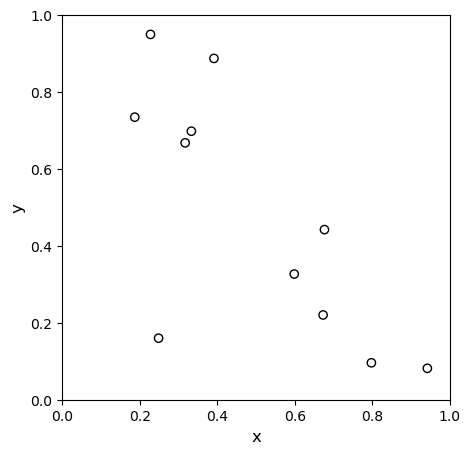

In [80]:
#########################################################################################################################
# set the seed for randon number generation; this ensures we get the same "random" number set each time we run the cell #
#########################################################################################################################
 
rng   = np.random.default_rng(12345)

#########################################################################################################################
# Generate 11 random x values and 11 random y values; print the results to screen                                       #
#########################################################################################################################

xdata = rng.random(11)
ydata = rng.random(11)
print(xdata, '\n')
print(ydata, '\n')

#########################################################################################################################
# Graph the 11 random (x,y) pairs on a scatterplot                                                                      #
#########################################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

#### Fitting the data

Our data set is comprised of 11 $(x,y)$ pairs. We have 11 $(n+1)$ data points. This means that we can find one unique $10^{th}$ order polynomial that passes through each of the 11 data points exactly. 

##### Creating the X matrix

Let's create that $X$ matrix representation of a 10th order polynomial.

In [81]:
####################################################################################################################
# Manual generation of the X matrix from xdata; each column corresponds to a specific power of x in the polynomial #
####################################################################################################################

X1 = np.ones((11,11))
X1[:,0]  = xdata**10
X1[:,1]  = xdata**9
X1[:,2]  = xdata**8
X1[:,3]  = xdata**7
X1[:,4]  = xdata**6
X1[:,5]  = xdata**5
X1[:,6]  = xdata**4
X1[:,7]  = xdata**3
X1[:,8]  = xdata**2
X1[:,9]  = xdata

####################################################################################################################
# The lines below display the the result of each value in xdata raised to a specified power                        # 
# These should be compared with the columns in the X matrix.                                                       # 
# You should be able to identify columns that correspond to each power                                             #
####################################################################################################################

power = 0
print(np.round(np.reshape(xdata**power, (len(xdata),1)), 2), '\n')
print(np.round(X1, 2))

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]] 

[[0.   0.   0.   0.   0.   0.   0.   0.01 0.05 0.23 1.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.03 0.1  0.32 1.  ]
 [0.1  0.13 0.16 0.2  0.26 0.32 0.4  0.51 0.64 0.8  1.  ]
 [0.02 0.03 0.04 0.06 0.1  0.14 0.21 0.31 0.46 0.68 1.  ]
 [0.   0.   0.   0.   0.   0.01 0.02 0.06 0.15 0.39 1.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.04 0.11 0.33 1.  ]
 [0.01 0.01 0.02 0.03 0.05 0.08 0.13 0.21 0.36 0.6  1.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.01 0.03 0.19 1.  ]
 [0.02 0.03 0.04 0.06 0.09 0.14 0.2  0.3  0.45 0.67 1.  ]
 [0.55 0.58 0.62 0.66 0.7  0.74 0.79 0.84 0.89 0.94 1.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.02 0.06 0.25 1.  ]]


##### Constructing the Y array

We can also create the $Y$ array -- this is simply the array of observed values $(y)$ from our data set. 

```{note}
The order of the data is important -- we need to remember that each value of our observable, measured quantity $"y"$ is always observed at a correponding value of our input variable $"x"$. For this reason, the first row in our $X$ array corresponds to the first value of $x$ in our data set; the second row in our $X$ array corresponds to the second value of $x$ in our data set; and so on until we reach the $11^{th}$ row, which corresponds to the $11^{th}$ value of $x$ in our data set. The entries in the $Y$ array follow the same order -- the first element is the value of $y$ observed at the first value of $x$, the second element in $Y$ is the value of $y$ observed at the second value of $x$, and so on until we reach the $11^{th}$ element in $Y$ which is the value of $y$ observed at the $11^{th}$ value of $x$.
``` 

In [82]:
################################################################################
# Y is the array of our measured or observed values                            #
################################################################################

Y1 = ydata
print(Y1)

[0.94888115 0.66723745 0.09589794 0.44183967 0.88647992 0.6974535
 0.32647286 0.73392816 0.22013496 0.08159457 0.1598956 ]


##### Solving for the unknown coefficients

Now, solve for A using `np.linalg.solve()`; this will give us the 11 coefficients needed to describe a 10th order polynomial

In [83]:
A = np.linalg.solve(X1, Y1)
print(A)

[-1.90239510e+07  1.01073201e+08 -2.35197349e+08  3.15169115e+08
 -2.68926703e+08  1.52477761e+08 -5.81160612e+07  1.46917321e+07
 -2.35630364e+06  2.16419264e+05 -8.64128002e+03]


##### Constructing the interpolating polynomial

Now, let's use those coefficients to create a polynomial of 10th order that can accept vector arguments. We will do this by defining a lambda function. Once we build the function, we will pass a 100 element set of $x$ values to create a smooth line between $x = 0$ and $x = 1$. We will see that this line passes exactly through each of the 11 data points! We will make no comment yet as to what the line does between those measured points.

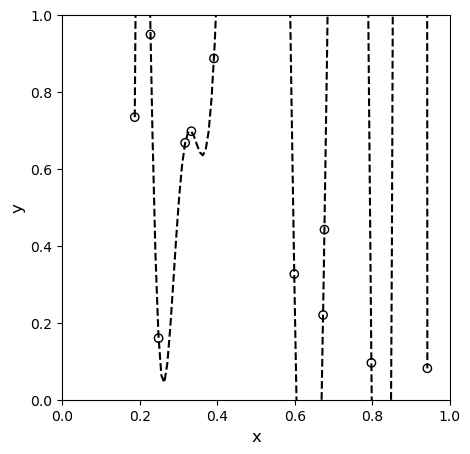

In [84]:
###################################################################################################
# Construct a 10th order polynomial using the coefficients that we solved for above               #
###################################################################################################

yline = lambda x: A[0]*x**10 + A[1]*x**9 + A[2]*x**8 + A[3]*x**7 + A[4]*x**6 + A[5]*x**5 + A[6]*x**4 + A[7]*x**3 + A[8]*x**2 + A[9]*x + A[10]

###################################################################################################
# Graph discrete (x,y) pairs from data set; overlay plot of continuous 10th order polynomial      #
###################################################################################################

xline = np.linspace(min(xdata), max(xdata), 100)
plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

##### Now pump the brakes...

Let's zoom out a bit and plot our data and the polynomial overlay on a larger y axis. As we do this, remember: the intent of this interpolating function that we have just constructed is that it is ***supposed to*** precisely describe the behavior of $y$ as a function of $x$ so that we can use it to predict values of $y$ at values of $x$ between the points we have measured.

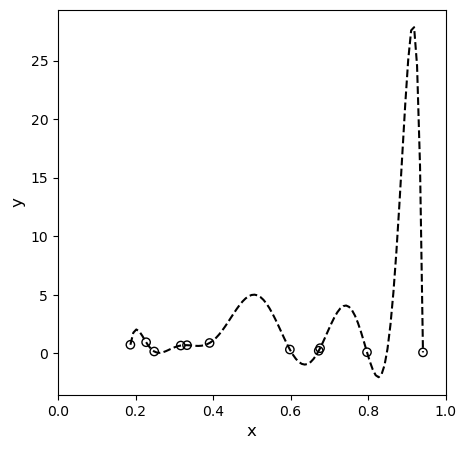

In [85]:
################################################################################################
# Graphing function behavior on larger y limits; do we believe the predictions?                #
################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.xlim(0, 1)
plt.show()

This doesn't inspire confidence. There is no reason to believe the y data should follow the behavior suggested by the dashed line in between the measured values. We should note that all of our measured $y$ values were between 0 and 1. Without some insight to the contrary, it does not make sense that we would measure y $\approx$ 5 at x $\approx$ 0.5, or y $\approx$ 30 at x $\approx$ 0.9. This is a red flag in data fitting...

What has happened is that we have over-fit the available data, and our model is capturing the "wiggles" (noise, imprecision) in the data with a mathematically rigorous equation. The problem is that we have used such a high order polynomial here y values are going to be extremely sensitive to small changes in the input value of $x$. Further, our model will have considerable curvature, and we may see that the function changes "direction" (i.e., does y increase a function of x or decrease as a function of x?) numerous times within the x-domain that we've considered. The upshot is that it is very likely that this model will predict physically nonsensical values of $y$ at any value of $x$ that we did not (1) explicitly measure and (2) include in the data fitting exercise where we created the interpolating polynomial. Another danger associated with high order polynomials--they have limited predictive power outside of the range where we fit them.  All polynomials go to $\pm \infty$ as the function arguments go to $\pm \infty$.  This actually happens really quickly for high order polynomials (see below for what happens when we try to use the model to predict what happens to y on the domain $x = (-2, 3)$.

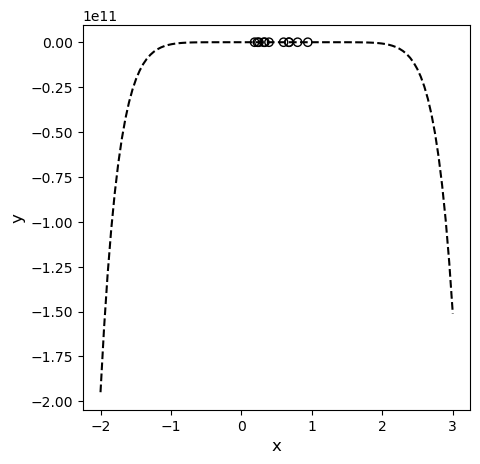

In [86]:
#################################################################################################################
# Graphing function behavior on larger x and y limits; all polynomials go to +/- ∞ eventually. Does your data?  #
#################################################################################################################

xline = np.linspace(-2, 3, 100)
plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.show()

```{caution}
The take home message is that we should be careful not to overfit data. Just because we have 11 data points, it isn't necessarily a good idea to fit a maximum order polynomial to them.  Also, we have to remember that these polynomials only describe what happens inside the limits where we have collected data.  Extrapolation beyond ranges where we've collected data is risky, and it is especially risky when we use complex, highly nonlinear models to describe the data.
```

```{figure} ../Images/ian-malcom-jurassic-park.gif
---
scale: 100%
name: IanMalcolm
---
Jurassic Park
```

## Let's call a Vandermonde Matrix a Vandermonde Matrix

The "X" matrix we used above is something that is used so frequently in data fitting that it is a well-known concept. It is called the Vandermonde matrix, and most programming languages include algorithms to facilitate construction of Vandermonde matrices. In Python, we can use `numpy.vander()`

In [87]:
##########################################################################################
# Constructing the X matrix using numpy.vander(); compare to manually generated X matrix #
##########################################################################################

X2 = np.vander(xdata)
print(np.round(X2, 2), '\n')
print(np.round(X1, 2), '\n')
print(X2.shape)

[[0.   0.   0.   0.   0.   0.   0.   0.01 0.05 0.23 1.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.03 0.1  0.32 1.  ]
 [0.1  0.13 0.16 0.2  0.26 0.32 0.4  0.51 0.64 0.8  1.  ]
 [0.02 0.03 0.04 0.06 0.1  0.14 0.21 0.31 0.46 0.68 1.  ]
 [0.   0.   0.   0.   0.   0.01 0.02 0.06 0.15 0.39 1.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.04 0.11 0.33 1.  ]
 [0.01 0.01 0.02 0.03 0.05 0.08 0.13 0.21 0.36 0.6  1.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.01 0.03 0.19 1.  ]
 [0.02 0.03 0.04 0.06 0.09 0.14 0.2  0.3  0.45 0.67 1.  ]
 [0.55 0.58 0.62 0.66 0.7  0.74 0.79 0.84 0.89 0.94 1.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.02 0.06 0.25 1.  ]] 

[[0.   0.   0.   0.   0.   0.   0.   0.01 0.05 0.23 1.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.03 0.1  0.32 1.  ]
 [0.1  0.13 0.16 0.2  0.26 0.32 0.4  0.51 0.64 0.8  1.  ]
 [0.02 0.03 0.04 0.06 0.1  0.14 0.21 0.31 0.46 0.68 1.  ]
 [0.   0.   0.   0.   0.   0.01 0.02 0.06 0.15 0.39 1.  ]
 [0.   0.   0.   0.   0.   0.   0.01 0.04 0.11 0.33 1.  ]
 [0.01 0.01

## Linear Regression

In cases where we have a lot of data, particularly when we have noisy (messy) data like we usually when making experimental measurements, we don't really want to "overfit" the data by building the maximum order polynomial permitted by the data available. Instead, we ***generally*** want to find a polynomial that adequately describes *trends* in data without *overfitting* the data.  This is the basic idea behind regression analysis -- it is a method wherein we seek to minimize the error between model predictionss and the measurement values (data) that we have available. How do we decide on the exact polynomial or functional form that should comprise our model? Ultimately, this is done by applying some intuition about the way that the system should behave (e.g., if we know that $y$ should scale linearly with $x$) and combining it with a critical examination of how well a given model describes our data.

To begin with ***regression analysis***, let's look at the random data set again, but we'll apply a critical eye and propose a model that makes sense instead of attempting to fit a maximum order polynomial.

```{note}
For reasons that will become apparent later, when we perform polynomial regressions of the type described here, we are performing ***linear regression***. It does not matter how nonlinear the model is because we are solving for coefficients (not x or y values), and nonlinear polynomials are linear in coefficients for known values of (x,y). Linear regression does not mean fitting data to a first order model -- it refers to using matrices to perform linear least squares analysis.
```

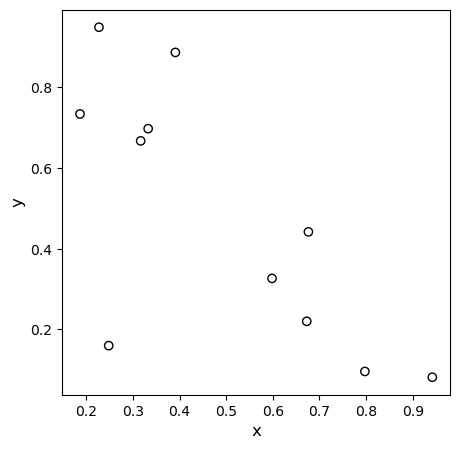

In [88]:
###########################################################################
# Prepare a scatterplot with the 11 random (x,y) pairs                    #
###########################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.show()

Let's start by acknowledging that we do not want to try to model the dependence of $y$ on $x$ using a $10^{th}$ order polynomial. As explained above, a $10^{th}$ order polynomial overfits the data and reduces its predictive power. Let's propose a different model -- we'll try to suggest something that can capture the overall ***trend*** in data or the ***shape*** of the data while ignoring noise. Looking at the data, we could reasonably suggest that the value of $y$ decreases linearly as the value of $x$ increases. This would motivate us to try to fit a ***first order model*** to the data. We can represent that model using the general form of a first order polynomial:

$$y(x) = \alpha_1x^1 + \alpha_0x^0$$

If we inspect this equation alongside the available data, we would eventually conclude that we have two unknown coefficients in that model, and we would like to determine their values. In this case, we will attempt to do so by leveraging the 11 data points we have available. One observation we might make upon reviewing the scatterplot of $(x,y)$ pairs is that we have 11 data points, and they are all scattered (this is done to simulate experimental noise). Visually, it should be very clear that there is no single straight line (first order model) that can pass through each data point. In mathematical terms, this comprises an overdetermiend system. In this case, our goal is not to find a straight line that passes through all data points -- it is to find the the one straight line that minimizes the error between the measured value of $y$ at a given value of $x$ and the value of $y$ predicted by the model for a given value of $x$. There are many ways to approach this, but the most common one is least squares regression. In this approach, we define a metric called the residual sum of squares:

$$\textrm{SSE} = \sum_i (y_i - \hat{y}_i)^2$$

Here, $y_i$ is $i^{th}$ value of our observable, $y_i$, measured at condition $x_i$, and $\hat{y}_i$ is the value of our observable $y_i$ predicted at condition $x_i$ by our model.

We will use least squares a lot in this course! In fact, whether you previously realized it or not+, least squares is embedded in a lot of the tools that most of us are probably are using already. The one most people are familiar with is Excel's trendline feature, which is performing linear least squares regression using whichever model you choose. Excel also has least squarest regression build into the very nice LINEST. The methods we will formalize here are also using in `numpy.polyfit()`. For now, we will frame linear regression as an extension of the matrix method that we developed for polynomial interpolation.  

We begin by stating that we are proposing that a first order (linear) model will adequately describe the dependence of $y$ on $x$. This means that we are proposing to use first order model (2 coefficients) to describe 11 $(x,y)$ pairs. We can write the linear model for each $(x,y)$ pair in our data set to generate the following system...

\begin{align}
    y_1    &= \alpha_1x_1 + \alpha_0 \\
    y_2    &= \alpha_1x_2 + \alpha_0 \\
    y_3    &= \alpha_1x_3 + \alpha_0 \\
    y_4    &= \alpha_1x_4 + \alpha_0 \\
    y_5    &= \alpha_1x_5 + \alpha_0 \\
    y_6    &= \alpha_1x_6 + \alpha_0 \\
    y_7    &= \alpha_1x_7 + \alpha_0 \\
    y_8    &= \alpha_1x_8 + \alpha_0 \\
    y_9    &= \alpha_1x_9 + \alpha_0 \\
    y_{10} &= \alpha_1x_{10} + \alpha_0 \\
    y_{11} &= \alpha_1x_{11} + \alpha_0 \\
\end{align}

In that set of equations, we know all of the $(x,y)$ entries because we have a measured or observed value of $y$ at every corresponding $x$. We do not know the values of the coefficients $\alpha_1$ and $\alpha_2$. This is what we are trying to solve for! But we have 11 equations written in terms of only 2 unknowns. This is an overdetermined system -- there is no way for us to satisfy each of these constrainte equation exactly, so there no unique solution for $(\alpha_0, \alpha_1)$ that will solve this system of equations. Instead, we need to minimize the error between measured values and predicted values. This is still a linear system since the problem is linear in our unknowns (all of the exponents on the alpha values are 1). As such, we can use linear algebra to estimate the "best" values for the unknown coefficients. We start by putting the above system in matrix form:

$$\begin{bmatrix} x_1^1 & x_1^0 \\ x_2^1 & x_2^0 \\ x_3^1 & x_3^0 \\ x_4^1 & x_4^0 \\ x_5^1 & x_5^0 \\ x_6^1 & x_6^0 \\ x_7^1 & x_7^0 \\ x_8^1 & x_8^0 \\ x_9^1 & x_9^0 \\ x_{10}^1 & x_{10}^0 \\ x_{11}^1 & x_{11}^0 \end{bmatrix} \times 
\begin{bmatrix} \alpha_1 \\ \alpha_0 \end{bmatrix} = 
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ y_4 \\ y_5 \\ y_6 \\ y_7 \\ y_8 \\ y_9 \\ y_{10} \\ y_{11} \\  \end{bmatrix}$$

Or, as usual:

$$XA = Y$$

We run into a problem when we try to solve this, though (see below)

In [89]:
Ya = ydata
# np.vander(xdata)
# np.round(np.vander(xdata), 2)
np.round(np.vander(xdata, 2), 2)
Xa = np.vander(xdata, 2) #This creates the X matrix shown above, truncating at 1st order
print(Xa)
print(Ya)

[[0.22733602 1.        ]
 [0.31675834 1.        ]
 [0.79736546 1.        ]
 [0.67625467 1.        ]
 [0.39110955 1.        ]
 [0.33281393 1.        ]
 [0.59830875 1.        ]
 [0.18673419 1.        ]
 [0.67275604 1.        ]
 [0.94180287 1.        ]
 [0.24824571 1.        ]]
[0.94888115 0.66723745 0.09589794 0.44183967 0.88647992 0.6974535
 0.32647286 0.73392816 0.22013496 0.08159457 0.1598956 ]


If we try to solve the matrix system with that X, though, we'll hit an error...

In [90]:
A = np.linalg.solve(Xa, Ya)

LinAlgError: Last 2 dimensions of the array must be square

This comes up because we can't invert a non-square matrix...(X is tall, not square)

In [ ]:
np.linalg.inv(Xa)

LinAlgError: Last 2 dimensions of the array must be square

The linear algebra way to approach this problem follows.  We start with our non-square X matrix, and we apply the following multiplication steps.  Note that multiplying X by its transpose will create a square matrix, which we can invert.

\begin{align}
    XA &= Y \\
    X^TXA &= X^TY \\
    \left(X^TX\right)^{-1}X^TXA &= \left(X^TX\right)^{-1}X^TY \\
    IA &= \left(X^TX\right)^{-1}X^TY \\
    A &= \left(X^TX\right)^{-1}X^TY \\
\end{align}

Believe it or not, that operation on the right hand side, $\left(X^TX\right)^{-1}X^TY$ actually minimizes the sum of squares for this linear problem.  This is a completely general result, and we can use a matrix method to solve for the optimum coefficients (giving the line of "best fit") for any problem that is linear in its coefficients.  See below.

In [ ]:
A = np.linalg.solve(Xa.T@Xa, Xa.T@Ya) 
#The above is equivalent to (but more memory efficient) than np.linalg.inv(X.T@X)@X.T@Y
print(A)

[-0.90421001  0.92118569]


Now we'll use those "optimum" coefficients to create the best fit straight line to our data set...

Note that since these are matrices, we can get our predicted Y values from the following relationship by matrix multiplication

$$\hat{Y} = X\hat{A}$$

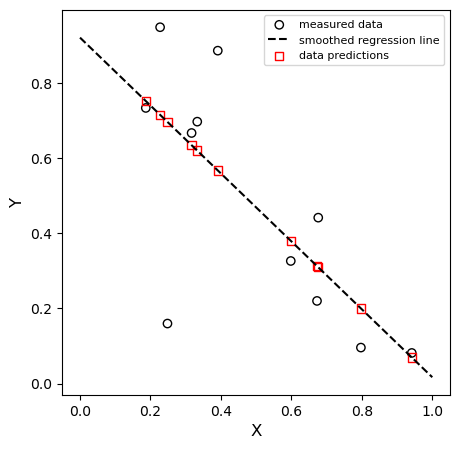

In [ ]:
xline = np.linspace(0, 1, 100)
yline = lambda x: A[0]*x + A[1]

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'measured data')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed', label = 'smoothed regression line')
plt.scatter(xdata, Xa@A, marker = 's', color = 'none', edgecolor = 'red', label = 'data predictions')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend(fontsize = 8)
plt.show()

Is it perfect?  No.  But this is the line that best describes our data.  We might alternatively choose a different model (2nd order, exponential function, etc), but if we want a straight line to model that system, this is as good as it gets.

Note that this is exactly the result we'd get if we put xdata and ydata into Excel, plotted them, and added a trendline.  If you try it, I am confident you'll find that:

1. slope = -0.904
2. y-intercept = 0.921

Why?  Because we just went through what trendline does under the hood.  Now you know!!

You want a quadratic fit?  No problem!!

[0.94888115 0.66723745 0.09589794 0.44183967 0.88647992 0.6974535
 0.32647286 0.73392816 0.22013496 0.08159457 0.1598956 ] 

[[0.05 0.23 1.  ]
 [0.1  0.32 1.  ]
 [0.64 0.8  1.  ]
 [0.46 0.68 1.  ]
 [0.15 0.39 1.  ]
 [0.11 0.33 1.  ]
 [0.36 0.6  1.  ]
 [0.03 0.19 1.  ]
 [0.45 0.67 1.  ]
 [0.89 0.94 1.  ]
 [0.06 0.25 1.  ]] 

[-0.69969354 -0.14991027  0.76170812]


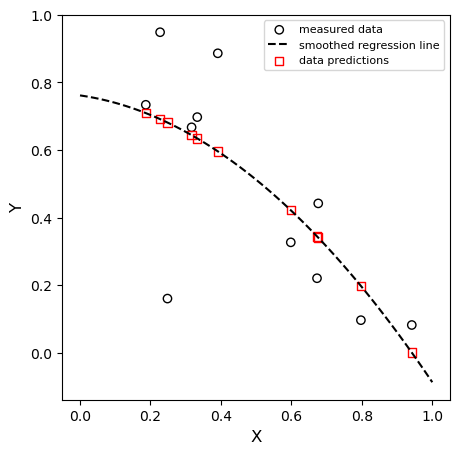

In [ ]:
Yb = ydata
Xb = np.vander(xdata,3)
print(Yb, '\n')
print(np.round(Xb, 2), '\n')
A = np.linalg.solve(Xb.T@Xb, Xb.T@Yb) 
print(A)
yline = lambda x: A[0]*x**2 + A[1]*x + A[2]
plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'measured data')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed', label = 'smoothed regression line')
plt.scatter(xdata, Xb@A, marker = 's', color = 'none', edgecolor = 'red', label = 'data predictions')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend(fontsize = 8)
plt.show()

Third order? Why not?

[0.94888115 0.66723745 0.09589794 0.44183967 0.88647992 0.6974535
 0.32647286 0.73392816 0.22013496 0.08159457 0.1598956 ] 

[[0.01 0.05 0.23 1.  ]
 [0.03 0.1  0.32 1.  ]
 [0.51 0.64 0.8  1.  ]
 [0.31 0.46 0.68 1.  ]
 [0.06 0.15 0.39 1.  ]
 [0.04 0.11 0.33 1.  ]
 [0.21 0.36 0.6  1.  ]
 [0.01 0.03 0.19 1.  ]
 [0.3  0.45 0.67 1.  ]
 [0.84 0.89 0.94 1.  ]
 [0.02 0.06 0.25 1.  ]] 

[ 4.85887321 -9.04727267  4.12600401  0.14299066]


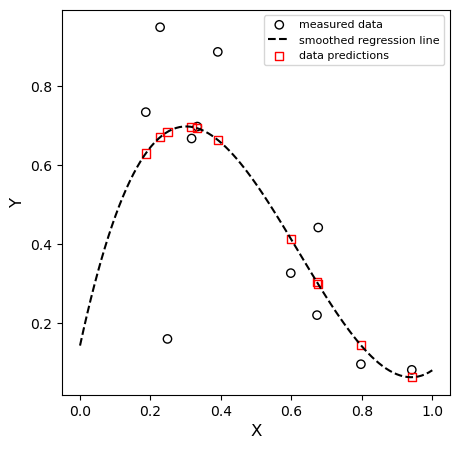

In [ ]:
Yc = ydata
Xc = np.vander(xdata,4)
print(Yc, '\n')
print(np.round(Xc, 2), '\n')
A = np.linalg.solve(Xc.T@Xc, Xc.T@Yc) 
print(A)
yline = lambda x: A[0]*x**3 + A[1]*x**2 + A[2]*x + A[3]

plt.figure(figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'measured data')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed', label = 'smoothed regression line')
plt.scatter(xdata, Xc@A, marker = 's', color = 'none', edgecolor = 'red', label = 'data predictions')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend(fontsize = 8)
plt.show()

And on it goes up to 10th order, where we have a unique solution.

## For Fall 2025: 

Consider stopping here.  The SSE and various other metrics start being useful around L30, and they would probably be retained better if introduced there instead of here.  Can truncate presentation to just focus on the coefficients and visually showing the line of best fit overlay.

### Extra, useful things to accompany regression

We calculate the residual sum of squares as usual:

$$SSE = \sum_i (y_i - \hat{y}_i)^2$$

Which, for a linear regression problem is equivalent to:

$$SSE = (Y - XA)^T(Y - XA)$$

In numpy that would be:

    SSE = (Y - X@A).T@(Y - X@A)

Mean Square Error is another useful metric. It quantifies the average square error in our data fit:

$$MSE = \frac{SSE}{n_m}$$

Where $n_m$ is the number of data points/measurements. From this, we can get the root mean square error, which is a good approximation of the absolute displacement (error) between our model and our measurement.

$$RMSE = \sqrt{MSE}$$

The total sum of squares quantifies the error between the measurement and the mean of measurments:

$$SST = \sum_i (y_i - \bar{y}_i)$$

If we have the residual and total sum of squares, we can calculate the coefficient of determination:

$$R^2 = 1 - \frac{SSE}{SST}$$

If you want to obtain estimates of standard error in the slope and y intercept that you regress, you need to estimate the covariance matrix.  First, we estimate the variance, $\sigma^2$ with the following:

$$\sigma^2 \approx s^2$$

and:

$$s^2 = \frac{SSE}{n_m - n_p}$$

Where $n_m$ is the number of measurements and $n_p$ is the number of regressed parameters.  This is also known as the "degrees of freedom" in our regression.

$$s^2 = \frac{SSE}{DOF}$$

With that, we can estimate the covariance matrix from the measured data:

$$COV = s^2(X^TX)^{-1}$$

The standard error in our regressed parameters is given by the diagonal elements in the following matrix:

$$se = \sqrt{COV}$$

Noting that this may throw a warning if off-diagonal elements of the covariance matrix are negative.

From that, we get the standard error in the slope from `se[0,0]` and the standard error in the intercept from `se[1,1]`, i.e., the diagonal elements.

If you want to calculate confidence intervals, they are given by:

$$CI = t(q, DOF)\times SE$$

Finally, noting that I'm working with a linear system, if I want to generate predicted values of my measured quantity (here ln(CA)), I can do so by multiplying my truncated vandermonde matrix by the regressed coefficients:

$$\hat{Y} = X\hat{A}$$

m    = -0.90 +/- 0.65
b    = 0.92 +/- 0.65
SSE  = 0.49
SST  = 1.03
MSE  = 0.04
RMSE = 0.21
R2   = 0.52


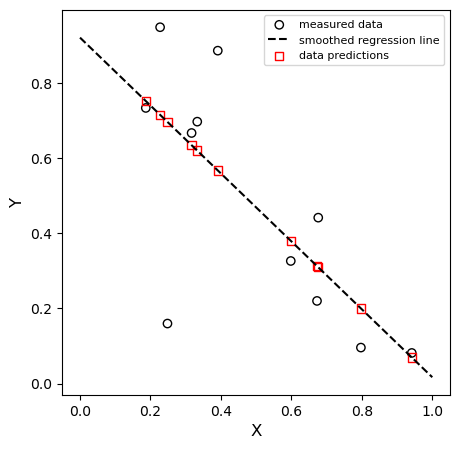

In [ ]:
Ya     = ydata
Xa     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order
A      = np.linalg.solve(Xa.T@Xa, Xa.T@Ya) 
Ypred  = Xa@A
Ybar   = np.mean(ydata)
Ndata  = len(ydata)
SSE1   = np.sum((Ya - Ypred)**2)
SSE2   = (Ya - Xa@A).T@(Ya - Xa@A)
SST    = np.sum((Ya - Ybar)**2)
MSE    = SSE1/Ndata
RMSE   = np.sqrt(MSE)
R2     = 1 - SSE1/SST
DOF    = len(ydata) - len(A)
s2     = SSE1/DOF
COV    = s2*np.linalg.inv(Xa.T@Xa)
m      = A[0]
b      = A[1]
SEm    = np.sqrt(COV[0, 0])
SEb    = np.sqrt(COV[1, 1])
tval   = stats.t.ppf(0.975, DOF)
CIm    = SEm*tval
CIb    = SEb*tval
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE,  R2]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.2f} +/- {CIm:0.2f}')
    else:
        print(f'{label:4s} = {value:0.2f}')

xline = np.linspace(0, 1, 100)
yline = lambda x: A[0]*x + A[1]
plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'measured data')
plt.plot(xline, yline(xline), color = 'black', linestyle = 'dashed', label = 'smoothed regression line')
plt.scatter(xdata, Xa@A, marker = 's', color = 'none', edgecolor = 'red', label = 'data predictions')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend(fontsize = 8)
plt.show()

## FYI, Python will do all this stuff for you if you want...

For your reference, Python will do most of this automatically through either np.polyfit or `np.linalg.leastsq()`

In [ ]:
A1 = np.polyfit(xdata, ydata, 1) #Fit a first order polynomial to data, two coefficients
A2 = np.polyfit(xdata, ydata, 2) #Fit a second order polynomial to data, three coefficients
A3 = np.polyfit(xdata, ydata, 3) #Fit a third order polynomial to data, four coefficients
print(A1)
print(A2)
print(A3)

[-0.90421001  0.92118569]
[-0.69969354 -0.14991027  0.76170812]
[ 4.85887321 -9.04727267  4.12600401  0.14299066]


Numpy is very nice because it will both do the regression for us (using `np.polyfit()`), and it will generate a polynomial for us so that we can make predictions (using `np.polyval()`).  This is an automated version of what we did above using matrices.

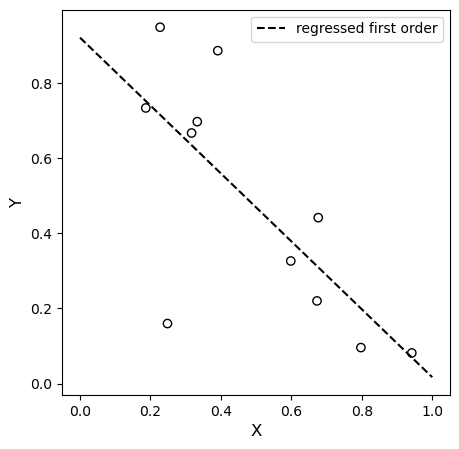

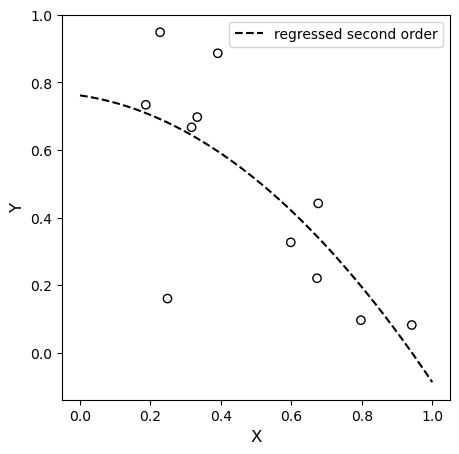

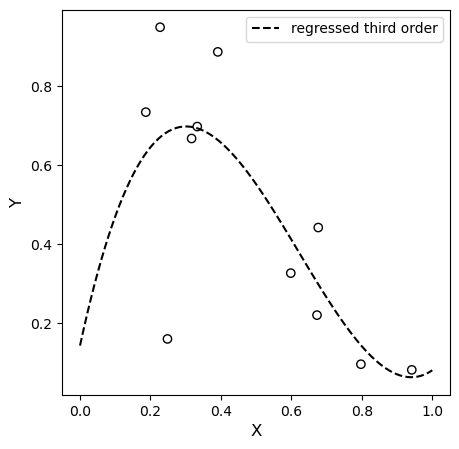

In [ ]:
first  = np.polyval(A1, xline)
second = np.polyval(A2, xline)
third  = np.polyval(A3, xline)

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, first, color = 'black', linestyle = 'dashed', label = 'regressed first order')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, second, color = 'black', linestyle = 'dashed', label = 'regressed second order')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend()
plt.show()

plt.figure(3, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(xline, third, color = 'black', linestyle = 'dashed', label = 'regressed third order')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.legend()
plt.show()

Numpy also has the least squares version of `np.linalg.solve()`, which has a very similar syntax and will return least squares regressed coefficients same as above.  See results below for a first and second order regression of our the "tall" matrices above.  These will return regressed coefficients and the minimum sum of squares.

In [ ]:
coeffs_1, SSE_1, cov_1, sing_1 = np.linalg.lstsq(Xa, Ya, rcond = None)
coeffs_2, SSE_2, cov_2, sing_2 = np.linalg.lstsq(Xb, Yb, rcond = None)
coeffs_3, SSE_3, cov_3, sing_3 = np.linalg.lstsq(Xc, Yc, rcond = None)
#np.linalg.lstsq(Xc, Yc, rcond = None)

print(coeffs_1, SSE_1)
print(coeffs_2, SSE_2)
print(coeffs_3, SSE_3)

[-0.90421001  0.92118569] [0.49163018]
[-0.69969354 -0.14991027  0.76170812] [0.47936939]
[ 4.85887321 -9.04727267  4.12600401  0.14299066] [0.45149249]
